<a href="https://colab.research.google.com/github/singhnidh/AgriGuard-A-Smart-Leaf-Disease-Detection-System-Leveraging-Attention-Mechanism-and-Ensemble-Learning/blob/main/Model/Attention_mechnism/Model_0_RESNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

# Specify the path to the directory containing your dataset
dataset_path = "/content/drive/MyDrive/ VIT_MT_PROJECT__2/ DATASET/Test_data"

# Get a list of class labels (subdirectories in the dataset path)
class_labels = os.listdir(dataset_path)

# Initialize a dictionary to store the count for each class
class_counts = {}

# Initialize a variable to store the total count
total_count = 0

# Loop through each class label
for label in class_labels:
    # Construct the path to the class directory
    class_path = os.path.join(dataset_path, label)

    # Count the number of images in the class directory
    num_images = len(os.listdir(class_path))

    # Store the count in the dictionary
    class_counts[label] = num_images

    # Increment the total count
    total_count += num_images

# Print the class labels and their respective counts
for label, count in class_counts.items():
    print(f"Class: {label}, Number of Images: {count}")

# Print the total number of images
print(f"Total Number of Images: {total_count}")


Mounted at /content/drive
Class: Apple healthy, Number of Images: 431
Class: Bell Pepper Bacterial spot, Number of Images: 300
Class: Bell Pepper healthy, Number of Images: 396
Class: Blueberry healthy, Number of Images: 400
Class: Cherry (including sour) Powdery mildew, Number of Images: 319
Class: Cherry (including_sour) healthy, Number of Images: 173
Class: Corn (maize) Cercospora leaf spot Gray leaf spot, Number of Images: 203
Class: Corn (maize) Common rust, Number of Images: 339
Class: Corn (maize) Northern Leaf Blight, Number of Images: 318
Class: Corn (maize) healthy, Number of Images: 337
Class: Grape Black rot, Number of Images: 436
Class: Grape Esca (Black Measles), Number of Images: 366
Class: Grape Leaf blight (Isariopsis Leaf Spot), Number of Images: 315
Class: Grape healthy, Number of Images: 164
Class: Potato Early blight, Number of Images: 317
Class: Potato Late blight, Number of Images: 200
Class: Potato healthy, Number of Images: 143
Class: Strawberry Leaf scorch, Nu

In [ ]:
import os
from keras.models import Model
from keras.layers import Input, Conv2D, Dense, GlobalAveragePooling2D, MaxPooling2D, concatenate, Activation, multiply, Dropout, Flatten
from keras.optimizers import Adam
!pip install livelossplot
from keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
from keras.callbacks import ModelCheckpoint, EarlyStopping
from pathlib import Path
import numpy as np
from livelossplot.inputs.keras import PlotLossesCallback
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
BATCH_SIZE = 64
input_shape = (224, 224, 3)
n_classes = 20

#------------------------------------------>>>>>>>  Data generators <<<<<<<<<<-------------------------------------#

train_generator = ImageDataGenerator(rotation_range=90,
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5,
                                     height_shift_range=0.5,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     validation_split=0.15)

test_generator = ImageDataGenerator()

download_dir = '/content/drive/MyDrive/VIT_MT_PROJECT__2/DATASET'
train_data_dir = '/content/drive/MyDrive/ VIT_MT_PROJECT__2/ DATASET/ Train_data'
test_data_dir = '/content/drive/MyDrive/ VIT_MT_PROJECT__2/ DATASET/Test_data'

class_subset = os.listdir('/content/drive/MyDrive/ VIT_MT_PROJECT__2/ DATASET/ Train_data')

traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)



Found 20508 images belonging to 20 classes.
Found 3608 images belonging to 20 classes.
Found 5806 images belonging to 20 classes.


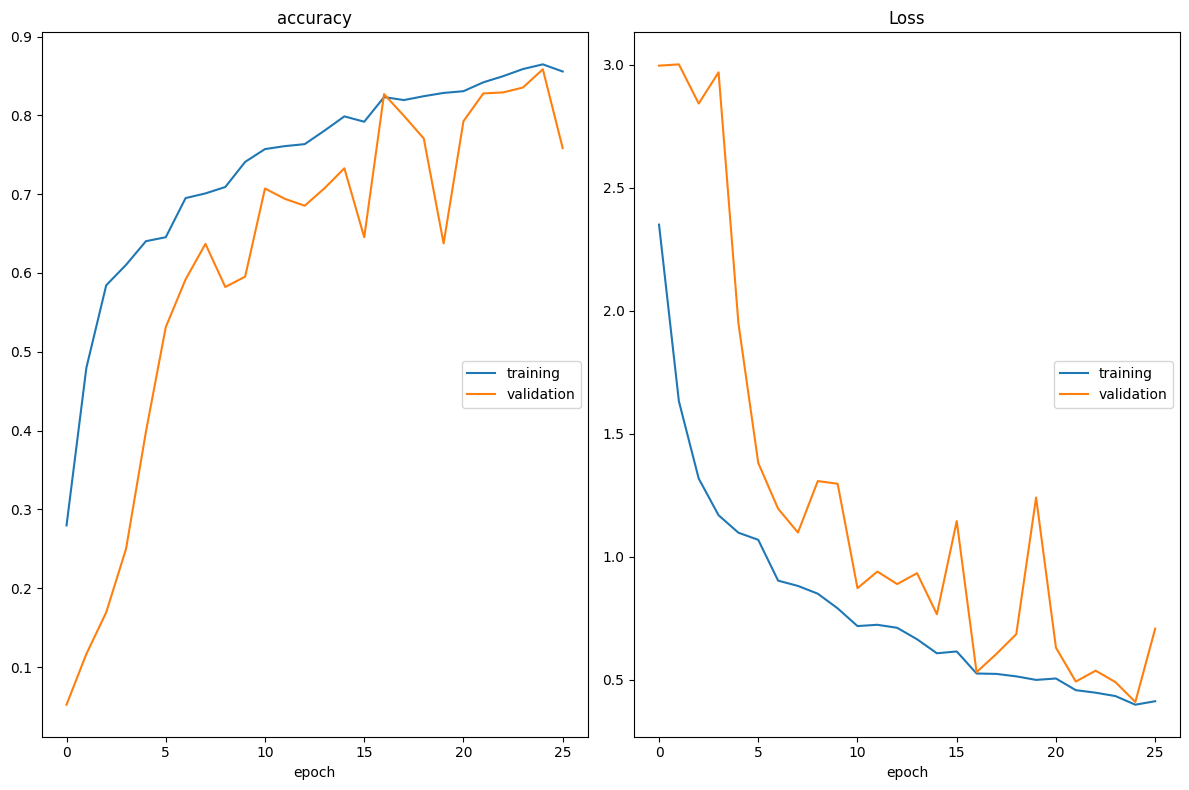

accuracy
	training         	 (min:    0.280, max:    0.865, cur:    0.856)
	validation       	 (min:    0.052, max:    0.858, cur:    0.758)
Loss
	training         	 (min:    0.399, max:    2.351, cur:    0.413)
	validation       	 (min:    0.410, max:    3.002, cur:    0.708)
50/50 [==============================] - 1677s 34s/step - loss: 0.4133 - accuracy: 0.8556 - val_loss: 0.7083 - val_accuracy: 0.7584
Epoch 27/30
20/50 [===========>..................] - ETA: 12:30 - loss: 0.3897 - accuracy: 0.8727

In [ ]:
#---------------------------------->>>>>>>  custom attention module <<<<<<<<<<------------------------------------#

def attention_module(x, g):
    theta_x = Conv2D(filters=int(x.shape[-1]), kernel_size=(1, 1), strides=(1, 1), padding='same')(x)
    phi_g = Dense(units=int(g.shape[-1]), activation='relu')(g)

    # Use a 1x1 convolutional layer on phi_g to maintain spatial dimensions
    conv_phi_g = Conv2D(filters=int(g.shape[-1]), kernel_size=(1, 1), strides=(1, 1), padding='same')(phi_g)

    # Reshape conv_phi_g to match spatial dimensions of theta_x
    reshaped_phi_g = Conv2D(filters=int(g.shape[-1]), kernel_size=(1, 1), strides=(1, 1), padding='same')(conv_phi_g)

    concat_xg = concatenate([theta_x, reshaped_phi_g], axis=-1)
    f = Activation('relu')(concat_xg)
    psi_f = Conv2D(filters=1, kernel_size=(1, 1), strides=(1, 1), padding='same')(f)
    rate = Activation('sigmoid')(psi_f)
    att_x = multiply([x, rate])
    return att_x

#---------------->>>>>>>  Custom ResNet50-like model with custom attention module <<<<<<<<<<----------------------#

def resnet50_attention_custom(input_shape, n_classes, optimizer='adam'):
    model_input = Input(shape=input_shape)

    # Conv1
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(model_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Attention Block
    att_x = attention_module(x, x)

    # Residual Blocks
    for _ in range(3):
        x = resnet_block(att_x, 64, 3)

    # Attention Block
    att_x = attention_module(x, x)

    for _ in range(4):
        x = resnet_block(att_x, 128, 3, strides=(2, 2))

    # Attention Block
    att_x = attention_module(x, x)

    for _ in range(6):
        x = resnet_block(att_x, 256, 3, strides=(2, 2))

    # Attention Block
    att_x = attention_module(x, x)

    for _ in range(3):
        x = resnet_block(att_x, 512, 3, strides=(2, 2))

    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    model_output = Dense(n_classes, activation='softmax')(x)

    model = Model(inputs=model_input, outputs=model_output)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()
    return model

def resnet_block(x, filters, kernel_size, strides=(1, 1)):
    res = x

    # First convolution
    x = Conv2D(filters, kernel_size, strides=strides, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    # Second convolution
    x = Conv2D(filters, kernel_size, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    # Resize the residual
    res = Conv2D(filters, (1, 1), strides=strides, padding='same')(res)

    # Add the residual
    x = concatenate([x, res])

    return x

#-------------------------->>>>>>> Create an instance of the model <<<<<<<<<<----------------------------#

optim_1 = Adam(learning_rate=0.0001)
n_epochs = 30
n_steps = 50 #traingen.samples // BATCH_SIZE
n_val_steps = 50 #validgen.samples // BATCH_SIZE


# Create an instance of the model
resnet_model_with_attention_custom_1 = resnet50_attention_custom(input_shape, n_classes, optim_1)

#-------------------------->>>>>>> ModelCheckpoint callback - save best weights <<<<<<<<<<----------------------------#

tl_checkpoint_2_custom = ModelCheckpoint(filepath='/content/drive/MyDrive/ VIT_MT_PROJECT__2/MODEL NOTEBOOK/Trained Model weight saved/model_0.1_Resnnet.weights.best.hdf5',
                                          save_best_only=True,
                                          verbose=1)

#-------------------------------------->>>>>>> EarlyStopping <<<<<<<<<<----------------------------------#

early_stop_custom = EarlyStopping(monitor='val_loss',
                                   patience=10,
                                   restore_best_weights=True,
                                   mode='min')

#----------------------->>>>>>> Training the model defined above with livelossplot callback <<<<<<<<<<----------------#

model_1_resnet = resnet_model_with_attention_custom_1.fit(
    traingen,
    batch_size=BATCH_SIZE,
    epochs=n_epochs,
    validation_data=validgen,
    steps_per_epoch=n_steps,
    validation_steps=n_val_steps,
    callbacks=[tl_checkpoint_2_custom, early_stop_custom, PlotLossesCallback()],
    verbose=1
)

#------------------------------------------->>>>>>>Saving the model <<<<<<<<<<----------------------------#

filepath_with_attention_custom_resnet = "/content/drive/MyDrive/ VIT_MT_PROJECT__2/MODEL NOTEBOOK/Trained Model weight saved/model_0.1_resnet.h5"
resnet_model_with_attention_custom_1.save(filepath_with_attention_custom_resnet)



In [ ]:
tl_checkpoint_2_custom = ModelCheckpoint(filepath='/content/drive/MyDrive/ VIT_MT_PROJECT__2/MODEL NOTEBOOK/Trained Model weight saved/model_0.1_Resnnet.weights.best.hdf5',
                                          save_best_only=True,
                                          verbose=1)

#-------------------------------------->>>>>>> EarlyStopping <<<<<<<<<<----------------------------------#

early_stop_custom = EarlyStopping(monitor='val_loss',
                                   patience=10,
                                   restore_best_weights=True,
                                   mode='min')


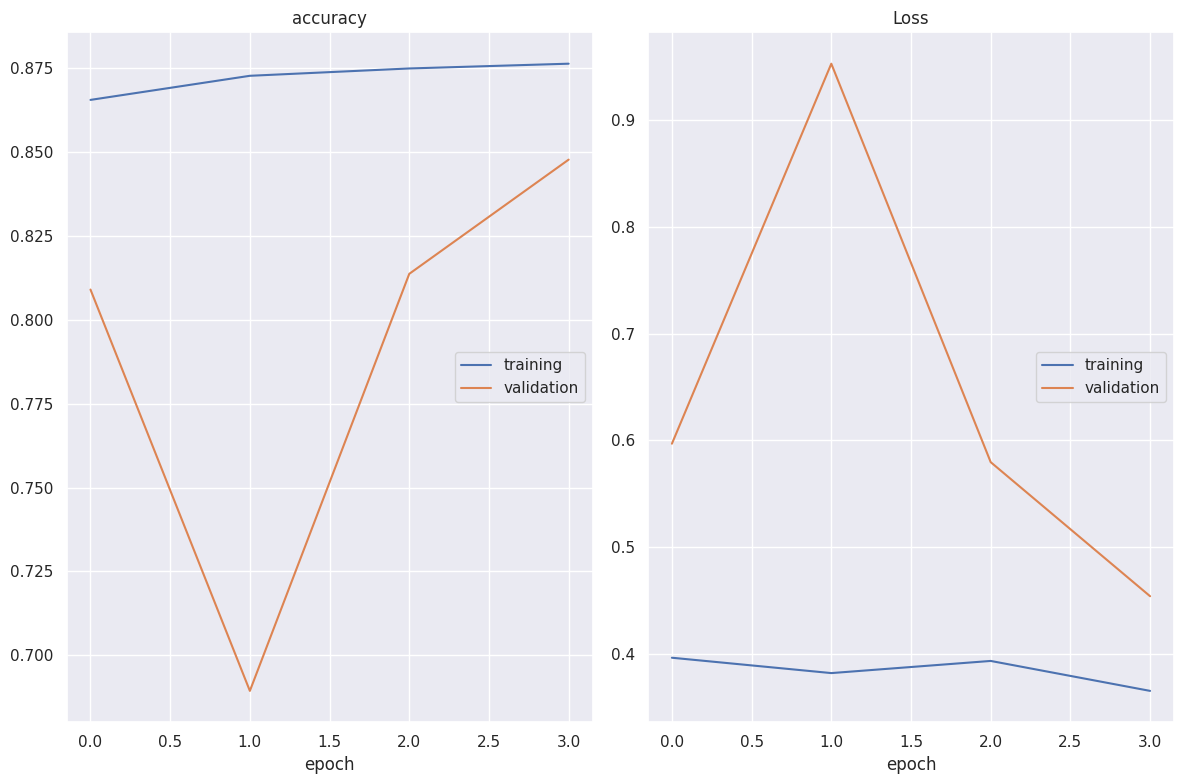

accuracy
	training         	 (min:    0.866, max:    0.876, cur:    0.876)
	validation       	 (min:    0.689, max:    0.848, cur:    0.848)
Loss
	training         	 (min:    0.365, max:    0.396, cur:    0.365)
	validation       	 (min:    0.454, max:    0.953, cur:    0.454)
50/50 [==============================] - 1490s 30s/step - loss: 0.3652 - accuracy: 0.8764 - val_loss: 0.4539 - val_accuracy: 0.8478


In [ ]:
from tensorflow.keras.models import load_model

optim_1 = Adam(learning_rate=0.0001)
n_epochs = 30
n_steps = 50 #traingen.samples // BATCH_SIZE
n_val_steps = 50 #validgen.samples // BATCH_SIZE

# Load the model
resnet_model_with_attention_custom_1 = load_model('/content/drive/MyDrive/ VIT_MT_PROJECT__2/MODEL NOTEBOOK/Trained Model weight saved/model_0.1_Resnnet.weights.best.hdf5')

# Specify the remaining number of epochs to train
remaining_epochs = n_epochs - 26  # Assuming you initially trained for 30 epochs

# Continue training the model with additional epochs
model_1_resnet = resnet_model_with_attention_custom_1.fit(
    traingen,
    batch_size=BATCH_SIZE,
    epochs=remaining_epochs,
    validation_data=validgen,
    steps_per_epoch=n_steps,
    validation_steps=n_val_steps,
    callbacks=[tl_checkpoint_2_custom, early_stop_custom, PlotLossesCallback()],
    verbose=1
)

#------------------------------------------->>>>>>>Saving the model <<<<<<<<<<----------------------------#

filepath_with_attention_custom_resnet = "/content/drive/MyDrive/ VIT_MT_PROJECT__2/MODEL NOTEBOOK/Trained Model weight saved/model_0.1_resnet.h5"
resnet_model_with_attention_custom_1.save(filepath_with_attention_custom_resnet)


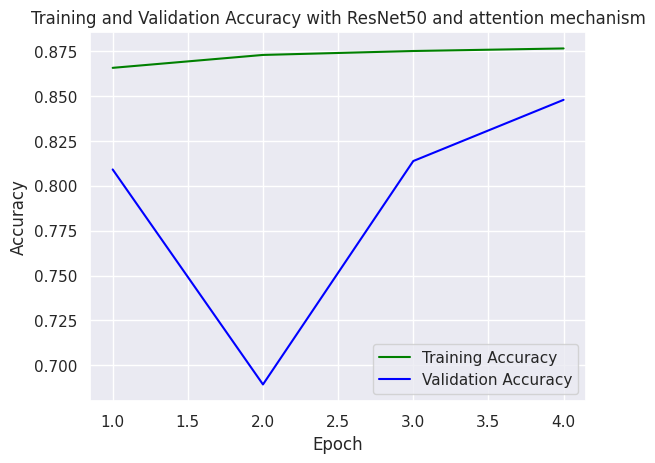

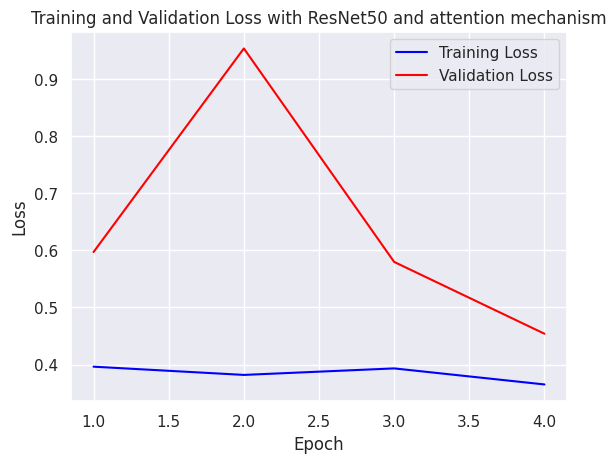

In [ ]:
#------------------------------------------->>>>>>>Plot training and validation graph<<<<<<<<<<----------------------------#

sns.set()
acc_resnet = model_1_resnet.history['accuracy']
val_acc_resnet = model_1_resnet.history['val_accuracy']
loss_resnet = model_1_resnet.history['loss']
val_loss_resnet = model_1_resnet.history['val_loss']
epochs_resnet = range(1, len(loss_resnet) + 1)

#accuracy plot
plt.plot(epochs_resnet, acc_resnet, color='green', label='Training Accuracy')
plt.plot(epochs_resnet, val_acc_resnet, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy with ResNet50 and attention mechanism')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.figure()

#loss plot
plt.plot(epochs_resnet, loss_resnet, color='blue', label='Training Loss')
plt.plot(epochs_resnet, val_loss_resnet, color='red', label='Validation Loss')
plt.title('Training and Validation Loss with ResNet50 and attention mechanism')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#------------------------------------------->>>>>>>Calculate model test accuracy <<<<<<<<<<----------------------------#

resnet_preds_attention_custom_1 = resnet_model_with_attention_custom_1.predict(testgen)
resnet_pred_classes_attention_custom_1 = np.argmax(resnet_preds_attention_custom_1, axis=1)
true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v, k) for k, v in class_indices.items())
class_names = testgen.class_indices.keys()

resnet_acc_attention_custom = accuracy_score(true_classes, resnet_pred_classes_attention_custom_1)
print("ResNet50 Model Accuracy with Custom Attention Mechanism: {:.2f}%".format(resnet_acc_attention_custom * 100))

5806/5806 [==============================] - 568s 98ms/step
ResNet50 Model Accuracy with Custom Attention Mechanism: 85.19%


In [ ]:
from tensorflow.keras.models import load_model

# Load the model
resnet_model_with_attention_custom_1 = load_model('/content/drive/MyDrive/ VIT_MT_PROJECT__2/MODEL NOTEBOOK/Trained Model weight saved/model_0.1_resnet.h5')


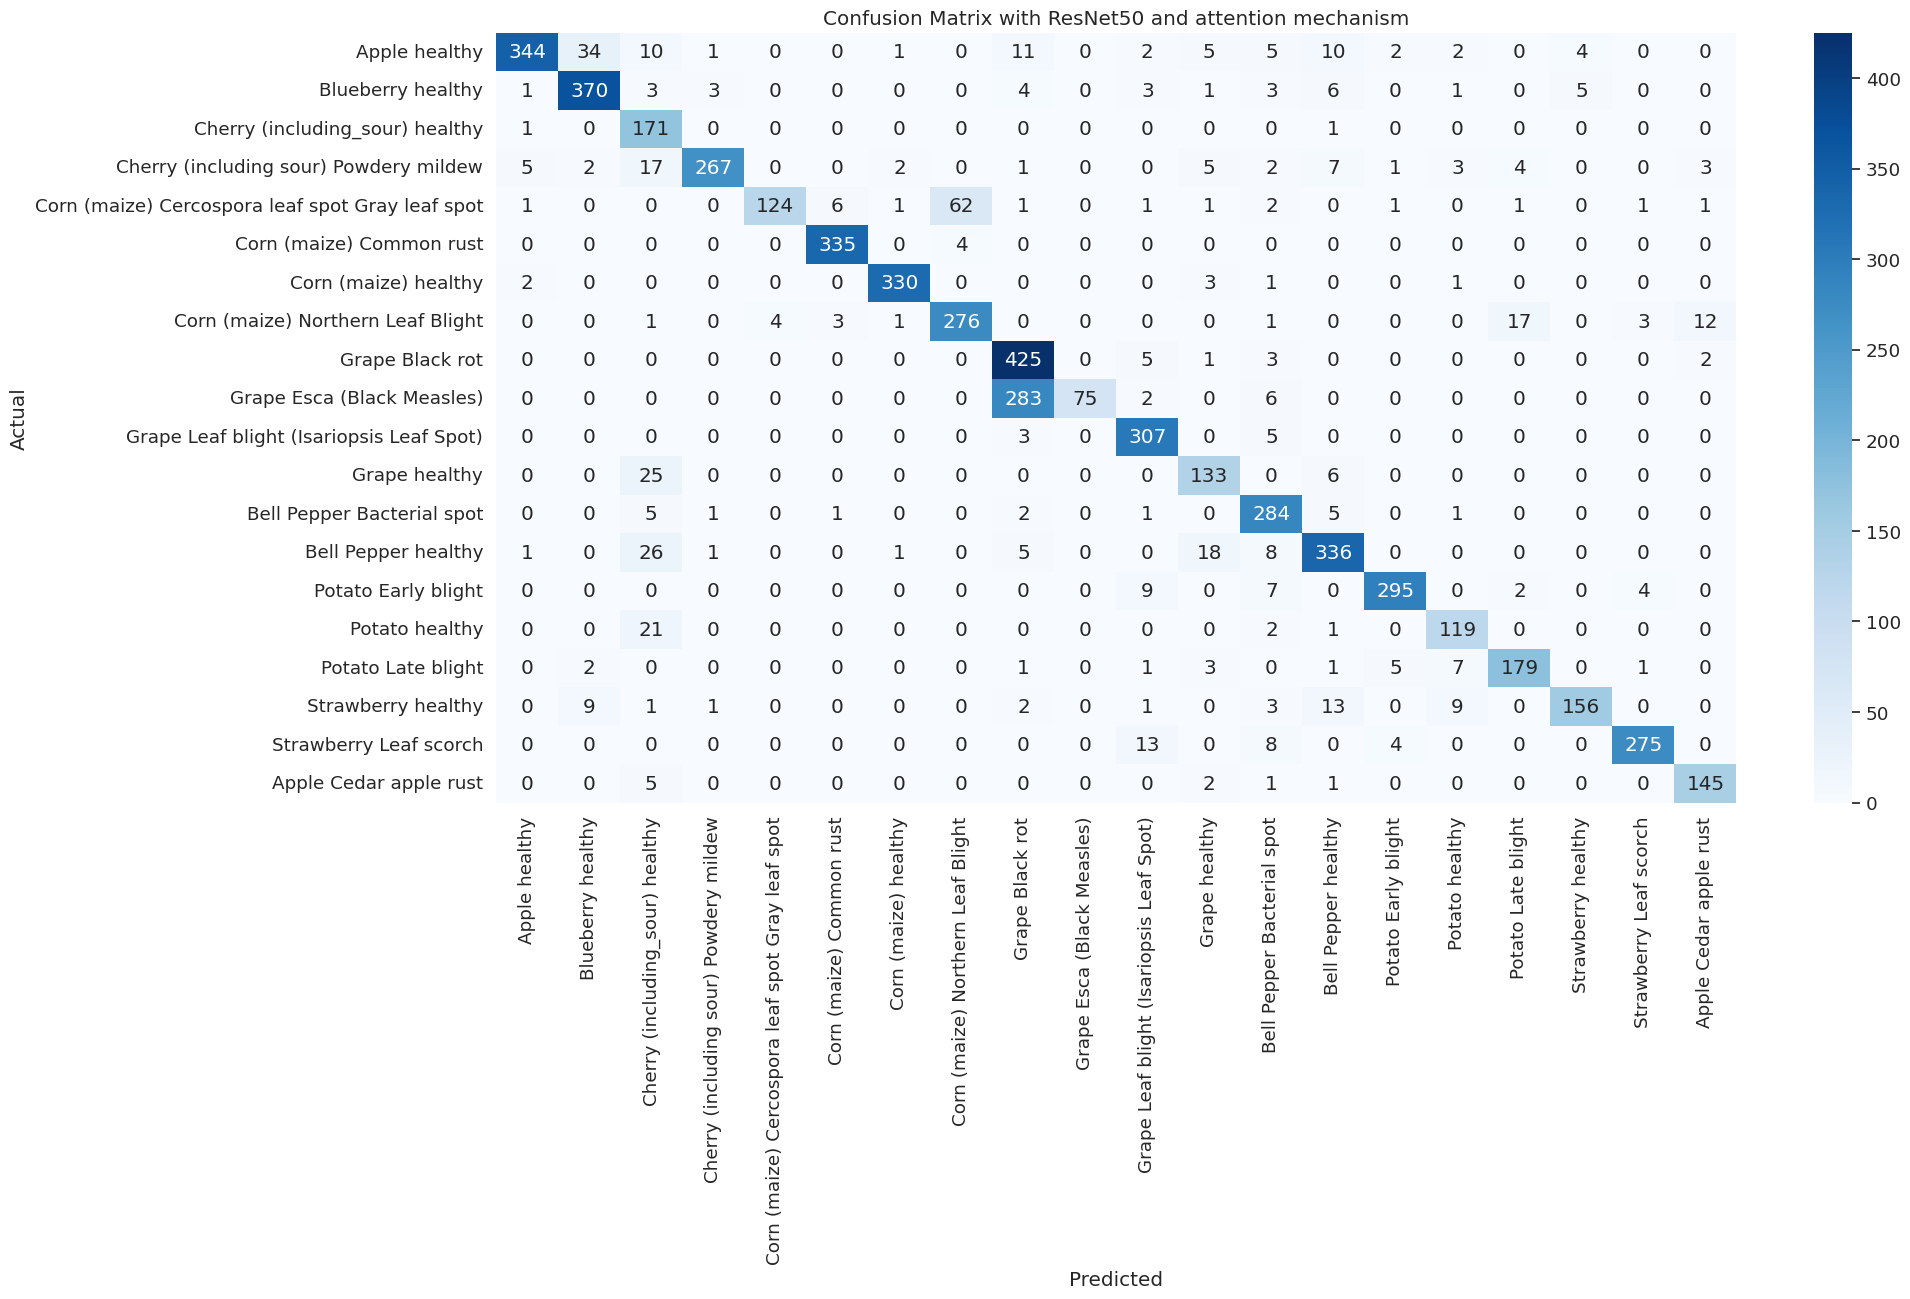

In [ ]:
#------------------------------------------->>>>>>>Draw confusion metrics <<<<<<<<<<----------------------------#
cm_resnet = confusion_matrix(true_classes, resnet_pred_classes_attention_custom_1)
plt.figure(figsize=(20,10))
sns.set(font_scale=1.2)
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with ResNet50 and attention mechanism')
plt.show()

In [ ]:
#------------------------------------------->>>>>>>Calculate metrics classification report<<<<<<<<<<----------------------------#
classification_rep_resnet = classification_report(true_classes, resnet_pred_classes_attention_custom_1)
precision_resnet = precision_score(true_classes, resnet_pred_classes_attention_custom_1, average='weighted', zero_division=True)
recall_resnet = recall_score(true_classes, resnet_pred_classes_attention_custom_1, average='weighted', zero_division=True)
f1_resnet = f1_score(true_classes, resnet_pred_classes_attention_custom_1, average='weighted', zero_division=True)
print("Confusion Matrix:")
print(cm_resnet)
print("\nClassification Report:")
print(classification_rep_resnet)
print(f"Precision (weighted): {precision_resnet:.4f}")
print(f"Recall (weighted): {recall_resnet:.4f}")
print(f"F1 Score (weighted): {f1_resnet:.4f}")

Confusion Matrix:
[[344  34  10   1   0   0   1   0  11   0   2   5   5  10   2   2   0   4
    0   0]
 [  1 370   3   3   0   0   0   0   4   0   3   1   3   6   0   1   0   5
    0   0]
 [  1   0 171   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0
    0   0]
 [  5   2  17 267   0   0   2   0   1   0   0   5   2   7   1   3   4   0
    0   3]
 [  1   0   0   0 124   6   1  62   1   0   1   1   2   0   1   0   1   0
    1   1]
 [  0   0   0   0   0 335   0   4   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  2   0   0   0   0   0 330   0   0   0   0   3   1   0   0   1   0   0
    0   0]
 [  0   0   1   0   4   3   1 276   0   0   0   0   1   0   0   0  17   0
    3  12]
 [  0   0   0   0   0   0   0   0 425   0   5   1   3   0   0   0   0   0
    0   2]
 [  0   0   0   0   0   0   0   0 283  75   2   0   6   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   3   0 307   0   5   0   0   0   0   0
    0   0]
 [  0   0  25   0   0   0   0   0   0   0   0 1

1/1 [==============================] - 2s 2s/step


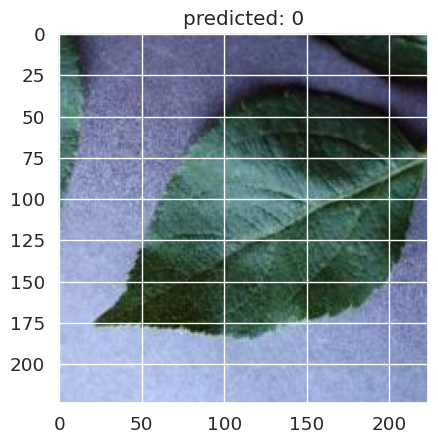

In [ ]:
#------------------------------------------->>>>>>>Pridict Image class<<<<<<<<<<----------------------------#

img_path_resnet = '/content/drive/MyDrive/ VIT_MT_PROJECT__2/ DATASET/Test_data/Apple healthy/aug_1000_2577.jpg'
img_resnet = image.load_img(img_path_resnet, target_size=(224, 224))

img_array_resnet = image.img_to_array(img_resnet)

img_array_resnet = np.expand_dims(img_array_resnet, axis=0)
img_array_resnet = preprocess_input(img_array_resnet)

predictions_resnet = resnet_model_with_attention_custom_1.predict(img_array_resnet)
predicted_resnet = resnet_pred_classes_attention_custom_1[np.argmax(predictions_resnet)]

plt.imshow(img_resnet)
plt.title('predicted: ' + str(predicted_resnet))
plt.show()


#**OUTPUT TILL 26 EPOCH**#

In [ ]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('/content/drive/MyDrive/ VIT_MT_PROJECT__2/MODEL NOTEBOOK/Trained Model weight saved/model_0.1_Resnnet.weights.best.hdf5')


In [ ]:
#------------------------------------------->>>>>>>Calculate model test accuracy <<<<<<<<<<----------------------------#

resnet_preds_attention_custom_1 = model.predict(testgen)
resnet_pred_classes_attention_custom_1 = np.argmax(resnet_preds_attention_custom_1, axis=1)
true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v, k) for k, v in class_indices.items())
class_names = testgen.class_indices.keys()

resnet_acc_attention_custom = accuracy_score(true_classes, resnet_pred_classes_attention_custom_1)
print("ResNet50 Model Accuracy with Custom Attention Mechanism: {:.2f}%".format(resnet_acc_attention_custom * 100))

5806/5806 [==============================] - 2145s 369ms/step
ResNet50 Model Accuracy with Custom Attention Mechanism: 86.74%


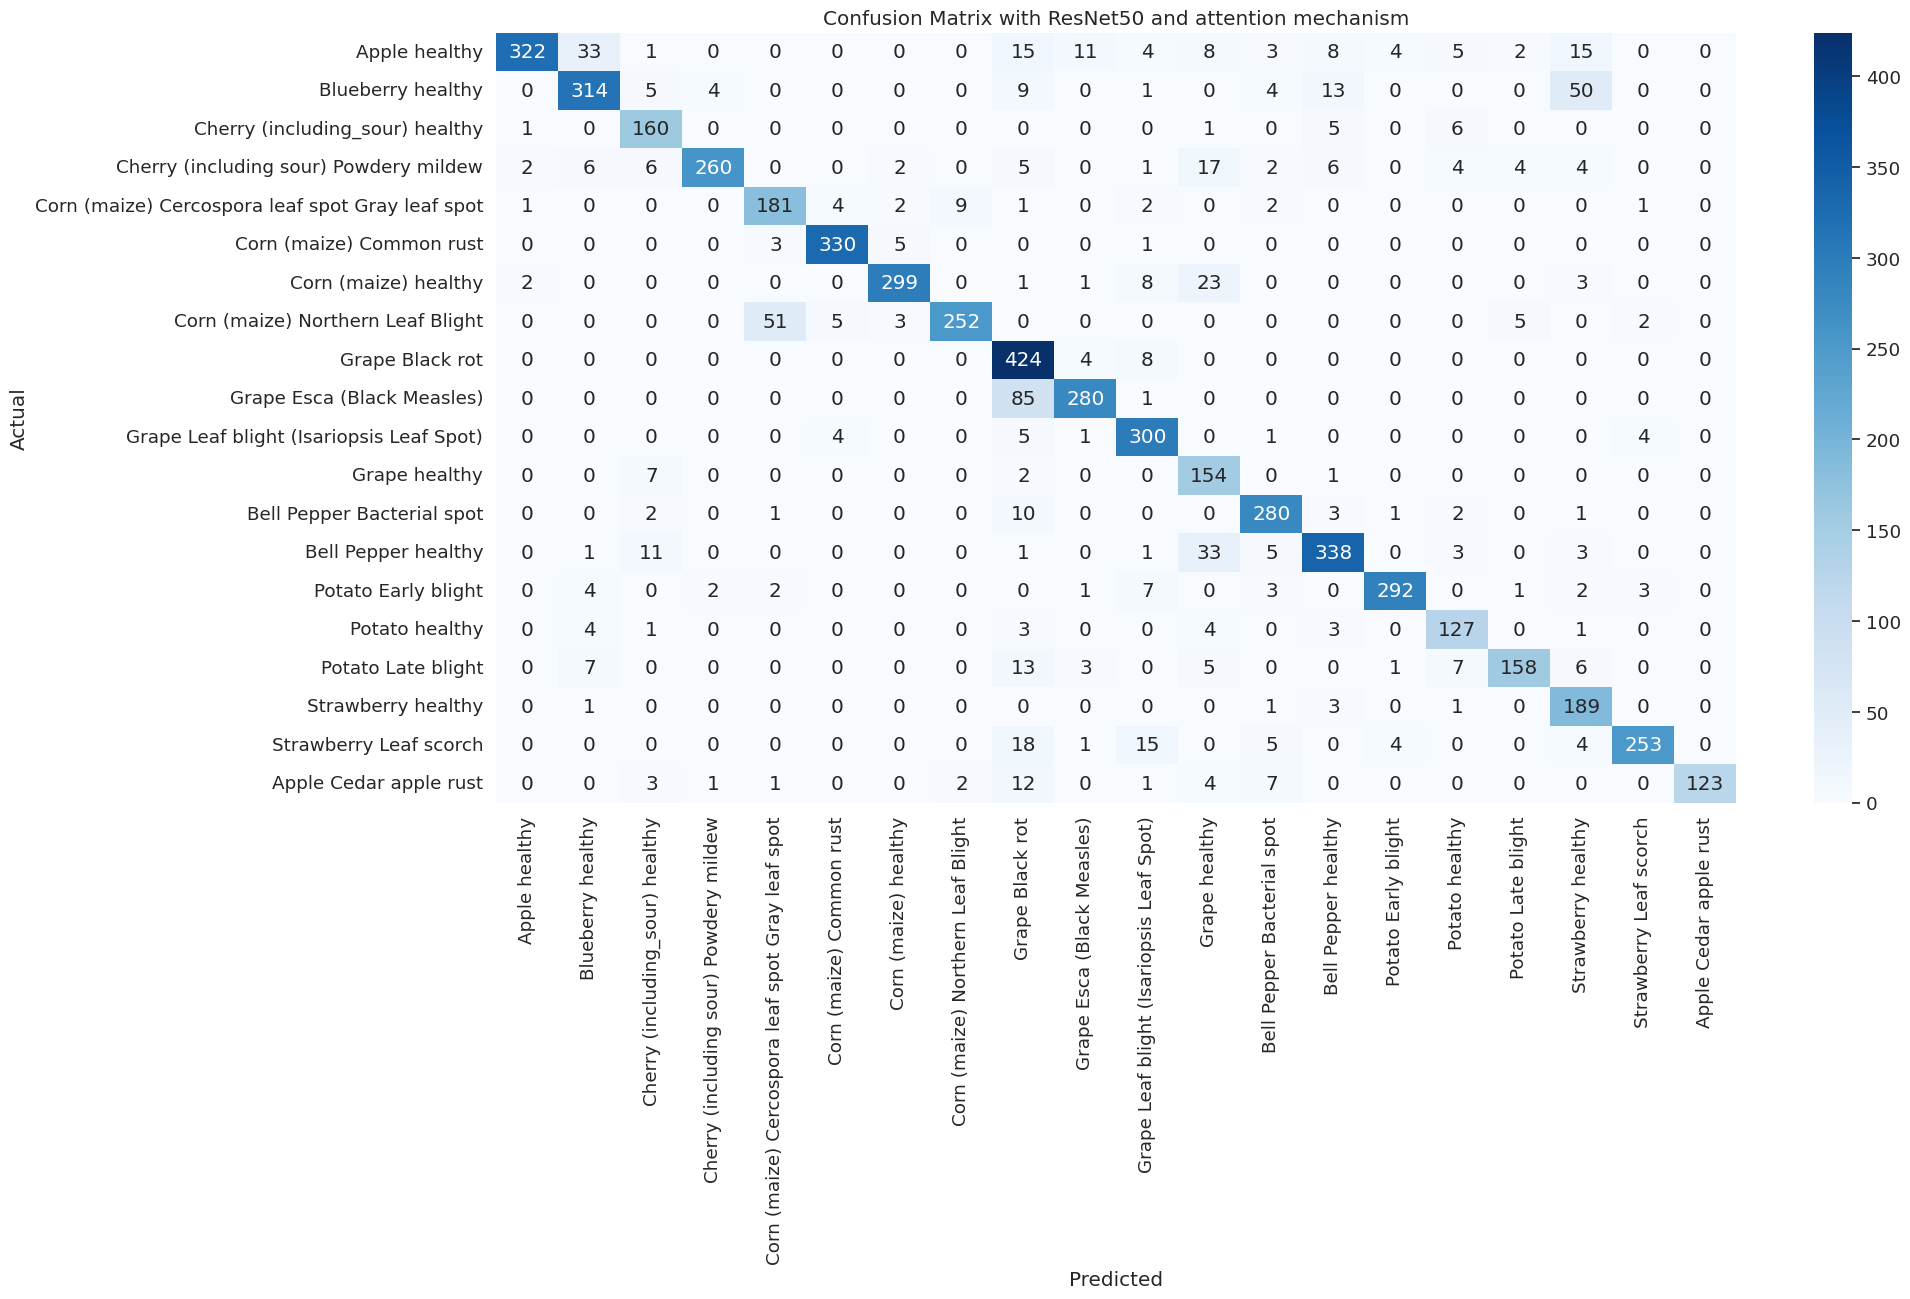

In [ ]:
#------------------------------------------->>>>>>>Draw confusion metrics <<<<<<<<<<----------------------------#

cm_resnet = confusion_matrix(true_classes, resnet_pred_classes_attention_custom_1)

plt.figure(figsize=(20,10))
sns.set(font_scale=1.2)
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with ResNet50 and attention mechanism')
plt.show()

In [ ]:
#------------------------------------------->>>>>>>Calculate metrics classification report<<<<<<<<<<----------------------------#

classification_rep_resnet = classification_report(true_classes, resnet_pred_classes_attention_custom_1)
precision_resnet = precision_score(true_classes, resnet_pred_classes_attention_custom_1, average='weighted', zero_division=True)
recall_resnet = recall_score(true_classes, resnet_pred_classes_attention_custom_1, average='weighted', zero_division=True)
f1_resnet = f1_score(true_classes, resnet_pred_classes_attention_custom_1, average='weighted', zero_division=True)
print("Confusion Matrix:")
print(cm_resnet)
print("\nClassification Report:")
print(classification_rep_resnet)
print(f"Precision (weighted): {precision_resnet:.4f}")
print(f"Recall (weighted): {recall_resnet:.4f}")
print(f"F1 Score (weighted): {f1_resnet:.4f}")

Confusion Matrix:
[[322  33   1   0   0   0   0   0  15  11   4   8   3   8   4   5   2  15
    0   0]
 [  0 314   5   4   0   0   0   0   9   0   1   0   4  13   0   0   0  50
    0   0]
 [  1   0 160   0   0   0   0   0   0   0   0   1   0   5   0   6   0   0
    0   0]
 [  2   6   6 260   0   0   2   0   5   0   1  17   2   6   0   4   4   4
    0   0]
 [  1   0   0   0 181   4   2   9   1   0   2   0   2   0   0   0   0   0
    1   0]
 [  0   0   0   0   3 330   5   0   0   0   1   0   0   0   0   0   0   0
    0   0]
 [  2   0   0   0   0   0 299   0   1   1   8  23   0   0   0   0   0   3
    0   0]
 [  0   0   0   0  51   5   3 252   0   0   0   0   0   0   0   0   5   0
    2   0]
 [  0   0   0   0   0   0   0   0 424   4   8   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0  85 280   1   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   4   0   0   5   1 300   0   1   0   0   0   0   0
    4   0]
 [  0   0   7   0   0   0   0   0   2   0   0 1

1/1 [==============================] - 1s 663ms/step


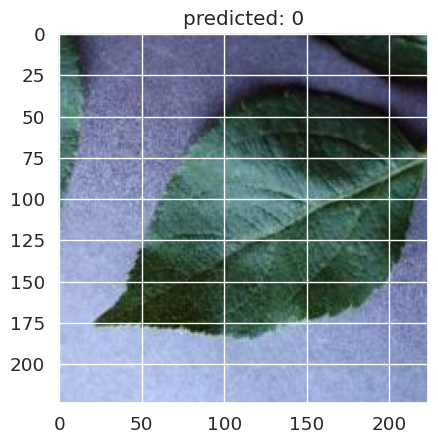

In [ ]:
#------------------------------------------->>>>>>>Pridict Image class<<<<<<<<<<----------------------------#

img_path_resnet = '/content/drive/MyDrive/ VIT_MT_PROJECT__2/ DATASET/Test_data/Apple healthy/aug_1000_2577.jpg'
img_resnet = image.load_img(img_path_resnet, target_size=(224, 224))

img_array_resnet = image.img_to_array(img_resnet)

img_array_resnet = np.expand_dims(img_array_resnet, axis=0)
img_array_resnet = preprocess_input(img_array_resnet)

predictions_resnet = model.predict(img_array_resnet)
predicted_resnet = resnet_pred_classes_attention_custom_1[np.argmax(predictions_resnet)]

plt.imshow(img_resnet)
plt.title('predicted: ' + str(predicted_resnet))
plt.show()
